<h3> Cleaning scraped data. </h3>
<p>
    Ses données on été scrapées sur plusieurs platforms. L'idée c'est de nettoyer ses données et les analysées.
</p>
<h3> Dépendances </h3>

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns

<h3> Chargement des fichiers de données et creation des DFs </h3>

In [41]:
def readDoorInsider(file_path):
    with open(file_path, encoding='utf-8') as f:
        data = json.load(f)

    result = []
    for df in data:
        df['surface_terrain'] = df['features']['Géneral'].get('Surface loi Carrez ', 0)
        df['nbSalleBain'] = df['features']['Géneral'].get('Salle(s) de bain', 0)
        df['balcon'] = 'Oui' if 'Chauffage' in df['features'] and 'Balcon' in df['features']['Chauffage'] else 'Non'
        df['terrace'] = 'Oui' if 'Chauffage' in df['features'] and 'Terrasse' in df['features']['Chauffage'] else 'Non'
        df['jardin'] = 'Oui' if 'Chauffage' in df['features'] and 'Jardin' in df['features']['Chauffage'] else 'Non'
        df['cuisine'] = 'Oui' if 'Cuisine' in df['features']  else 'Non'
        df['garage'] = 'Oui' if 'Chauffage' in df['features'] and 'Place de parking' in df['features']['Chauffage'] else 'Non'
        df['classEnergy'] = df['features'].get('classEnergy', 'ND')
        df['gazEmission'] = df['features'].get('gazEmission', 'ND')
        result.append(df)
        df.pop('features', None)

    return result

def readImmoRegion(file_path):
    with open(file_path, encoding='utf-8') as f:
        data = json.load(f)
    result = []
    for df in data:
        df['nbSalleBain'] = df.pop('toilletes')
        df['garage'] = df.pop('parking')
        if 'features' in df:
            df['surface_terrain'] = df['features'].get('Surface habitable', 0)
            df['balcon'] = 'Non'
            df['terrace'] = 'Oui' if 'Terrasse' in df['features'] else 'Non'
            df['cuisine'] = 'Oui' if 'Cuisine équipée' in df['features'] else 'Non'
            df['jardin'] = 'Oui' if 'Jardin' in df['features'] else 'Non'
            df['garage'] = 'Oui' if 'Place(s) de parking dans un garage' in df['features']  else 'Non'
            df['classEnergy'] = df['features'].get('Diagnostique de performance énergétique (DPE)Réalisé avant le 1er juillet 2021Logement à consommation énergétique excessive', 'ND')
            df['gazEmission'] = df['features'].get('Emission de gaz à effet de serre (GES)', 'ND')
            result.append(df)
            df.pop('features', None)
        else:
            result.append(df)
    return result

def readparuVenu(file_path):
    with open(file_path, encoding='utf-8') as f:
        data = json.load(f)
    result = []
    for df in data:
        df.pop('toilletes')
        df['garage'] = df.pop('parking')
        if 'features' in df:
            df['surface_terrain'] = df['features'].get('- Surface du terrain', 0)
            df['nbSalleBain'] = df['features'].get('- Nombre de salle(s) de bain', 0)
            df['balcon'] = 'Non'
            df['terrace'] = 'Oui' if 'Terrasse' in df['features'] else 'Non'
            df['jardin'] = 'Oui' if '- Mobilier de jardin' in df['features'] else 'Non'
            df['garage'] = 'Oui' if '- Garage extérieur' in df['features']  else 'Non'
            df['garage'] = 'Oui' if '- Parking' in df['features']  else 'Non'
            df['classEnergy'] = df['features'].get('classEnergy', 'ND')
            df['gazEmission'] = df['features'].get('gazEmission', 'ND')
            result.append(df)
            df.pop('features', None)
        else:
            result.append(df)
    return result




In [42]:
file1='../ScrappingV2/doorInsider/output/output.json'
doorInsider = readDoorInsider(file1)

In [43]:
file2='../ScrappingV2/immoRegion/output/output.json'
immoRegion = readImmoRegion(file2)

In [44]:
file3='../ScrappingV2/paruvenu/output/output.json'
paruVenu = readparuVenu(file3)

In [45]:
merged_list = []
merged_list.extend(paruVenu)
merged_list.extend(immoRegion)
merged_list.extend(doorInsider)

df = pd.DataFrame(merged_list)

<h3> Numerisation de certains valeurs </h3>

In [46]:
import re
# function to clean the pieces column
def clean_pieces(data):
    # convert non-string values to string
    data = str(data)
    
    # remove special characters and keep only numeric values
    data = re.sub('[^0-9]', '', data)
    
    # return the cleaned value as an integer
    return int(data) if data else None

In [47]:
# apply the clean_pieces function to the pieces column
df['pieces'] = df['pieces'].apply(clean_pieces)
df['surface_terrain'] = df['surface_terrain'].apply(clean_pieces)
df['nbSalleBain'] = df['nbSalleBain'].apply(clean_pieces)

<h3> Replacing none values in classEnergy and gazEmission by ND </h3>

In [48]:
df['classEnergy'].replace([None, 'none','NC'], 'ND', inplace=True)
df['gazEmission'].replace([None, 'none','NC'], 'ND', inplace=True)


<h4> Suppression de doublons</h4>
<p> La colonne ref est la référence d'une annonce donc les valeurs doivent être unique </p>

In [49]:
duplicate_ref = df.duplicated(subset='ref', keep=False)
number_of_duplicate = duplicate_ref.sum()
print(number_of_duplicate)

293


In [50]:
## we will drop the the duplicate
duplicate_ref = df.duplicated(subset='ref', keep=False)
df = df.drop_duplicates(subset='ref', keep='first')


<h4> Verification du percentage de valeurs null dans chaque colonne <h4>

In [51]:
# Calculate the percentage of null values in each column
def checkNullValues(df):
    null_vals = df.isnull().mean()
    null_vals = null_vals.sort_values(ascending=False).head(5)
    plt.figure(figsize=(10,5))
    sns.barplot(x=null_vals.index, y=null_vals.values)
    plt.xlabel('Columns')
    plt.ylabel('Percentage of Null Values')
    plt.show()



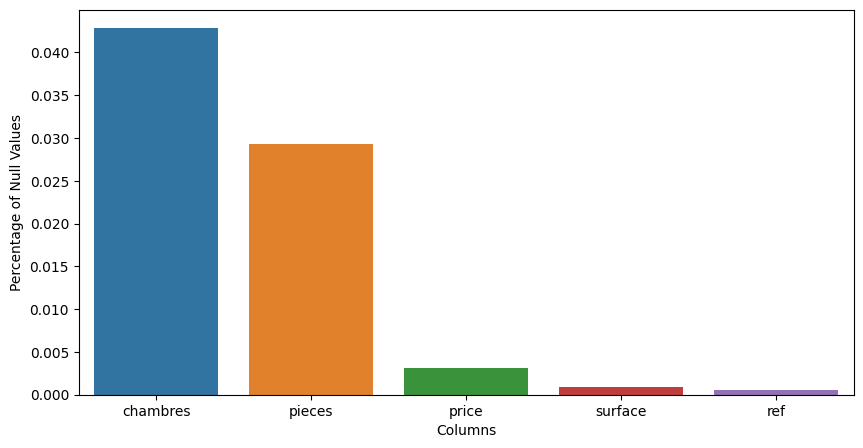

In [52]:
checkNullValues(df)

<h3> Suppression de certains columns qui vont faire partir de l'analyse </h3>

In [53]:
df = df.drop(["image","url","description"], axis=1)

<h3> Univariate Analysis </h3>

In [54]:
def countPlot(df:pd.DataFrame,x:str, percent:bool=True, size=(15,5))->None: # to plot a bargraph of percentage frequencies of a column
    plt.figure(figsize=size)
    chart = sns.countplot(
        data=df,
        x=x,
        order=df[x].value_counts().index
    )
    chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

    if percent==True: # to add value on the bar as percentage
        total = len(df[x])
        for p in chart.patches:
                percentage = f'{100 * p.get_height() / total:.3f}%\n'
                x = p.get_x() + p.get_width() / 2
                y = p.get_height()
                chart.annotate(percentage, (x, y), ha='center', va='center')
    else:
        chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
        for c in chart.containers:
            labels = [f'{(v.get_height()):.1f}' for v in c]
            chart.bar_label(c, labels=labels, label_type='edge')
    plt.ylabel('Percentage')
    plt.show()

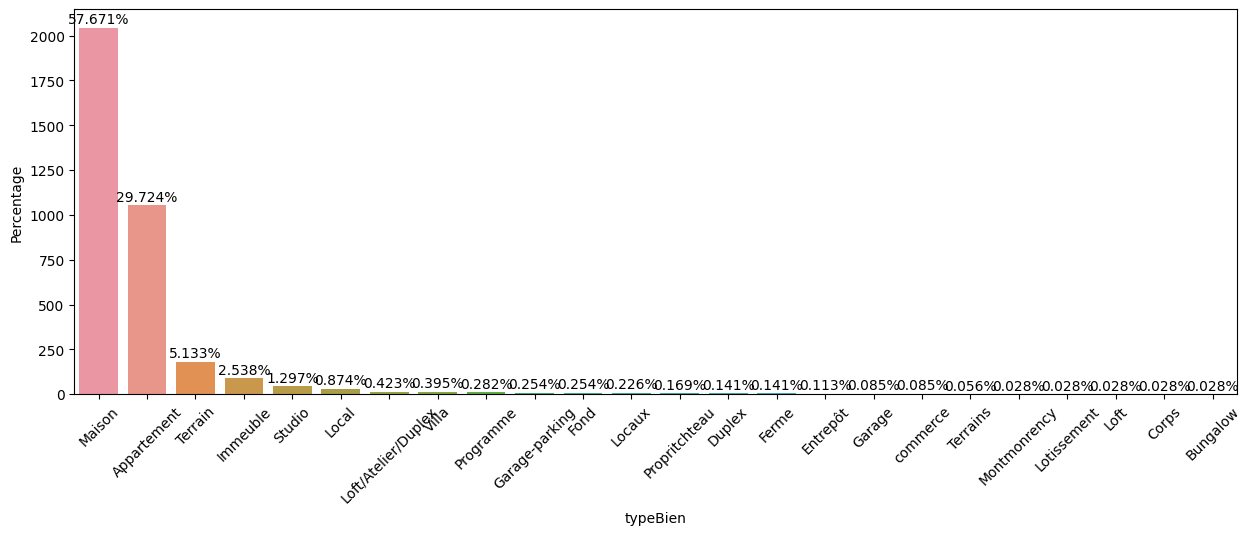

In [55]:
df_TypeVente = df.copy()
df_TypeVente = df_TypeVente.groupby('typeBien').filter(lambda x: len(x) > 0)
countPlot(df_TypeVente, "typeBien", True)

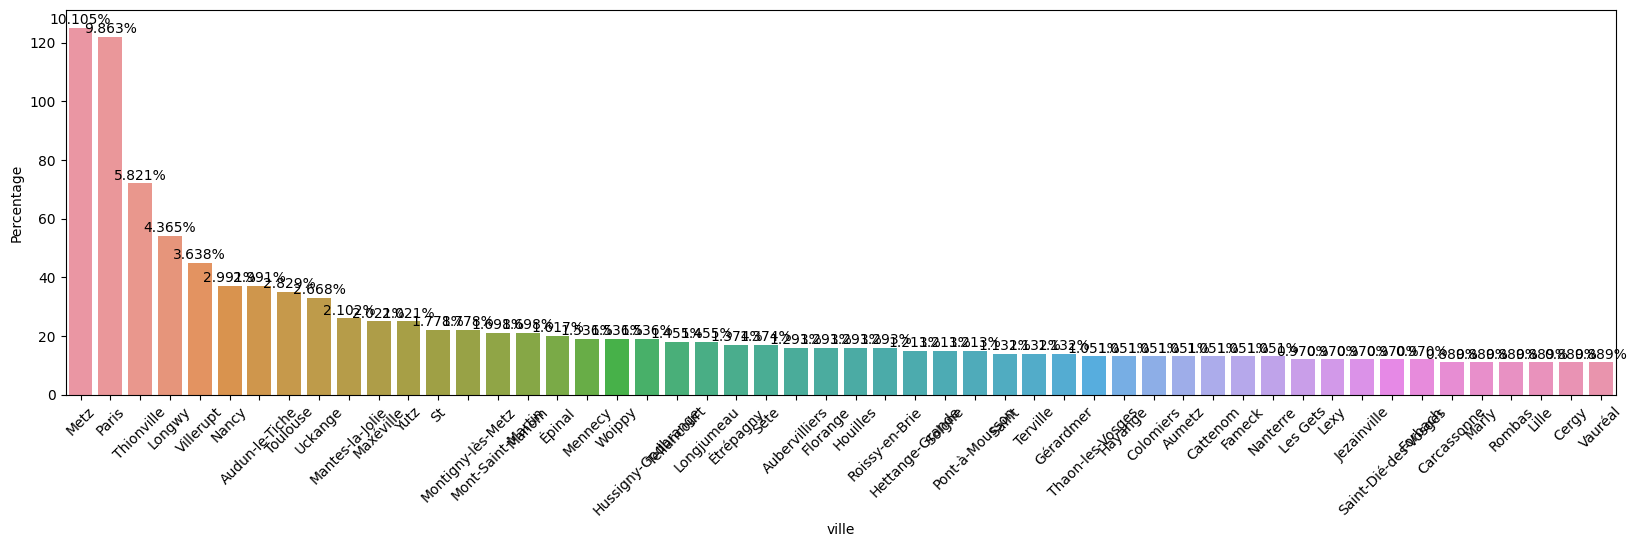

In [56]:
df_ville = df.copy()
df_ville = df_ville.groupby('ville').filter(lambda x: len(x) > 10)
countPlot(df_ville, "ville", True, (20,5))

In [57]:
def plot_boxplots(df: pd.DataFrame, column:str):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
    axes[0].set_title(column[0])
    axes[1].set_title(column[1])
    axes[2].set_title(column[2])
    df.boxplot(column[0], ax=axes[0], vert=False)
    df.boxplot(column[1], ax=axes[1], vert=False)
    df.boxplot(column[2], ax=axes[2], vert=False)
    fig.suptitle("Boxplots du dataset")
    # Remove the automatic label generation on plots
    axes[0].set_yticklabels([""])
    axes[1].set_yticklabels([""])
    axes[2].set_yticklabels([""])
    plt.show()
def plot_histogram(df: pd.DataFrame, column:str):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
    axes[0].set_title(column[0])
    axes[1].set_title(column[1])
    axes[2].set_title(column[2])
    df[column[0]].hist(bins=100, ax=axes[0])
    df[column[1]].hist(bins=100, ax=axes[1])
    df[column[2]].hist(bins=100, ax=axes[2])
    fig.suptitle("Distribution du dataset")
    # Remove the automatic label generation on plots
   
    plt.show()

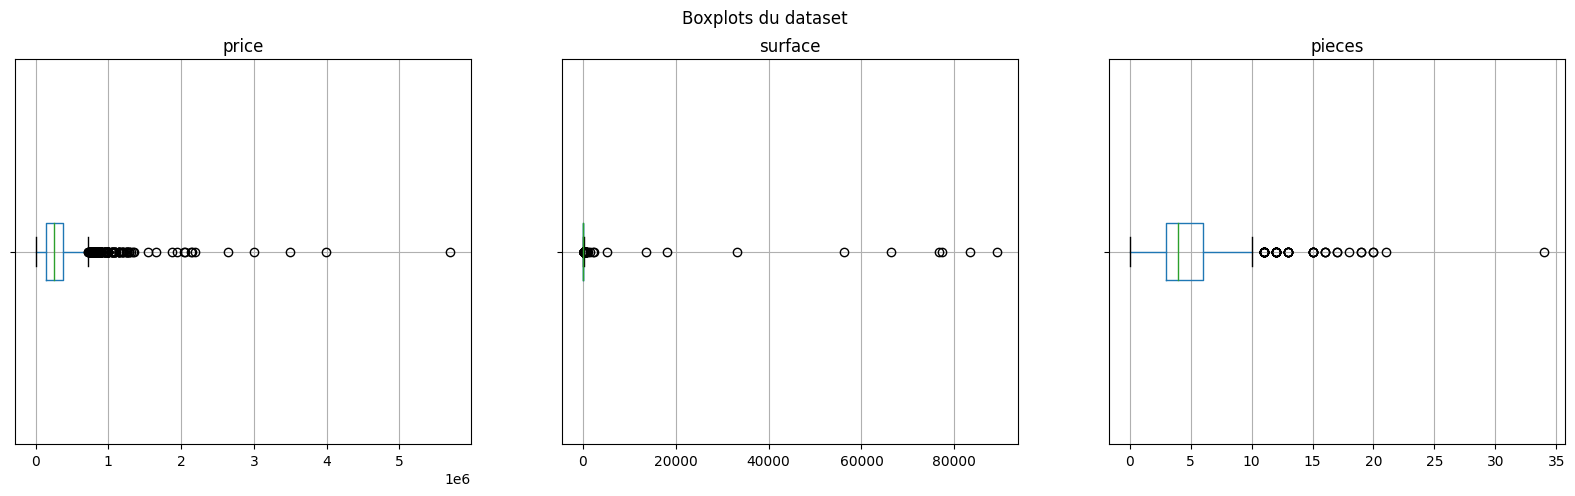

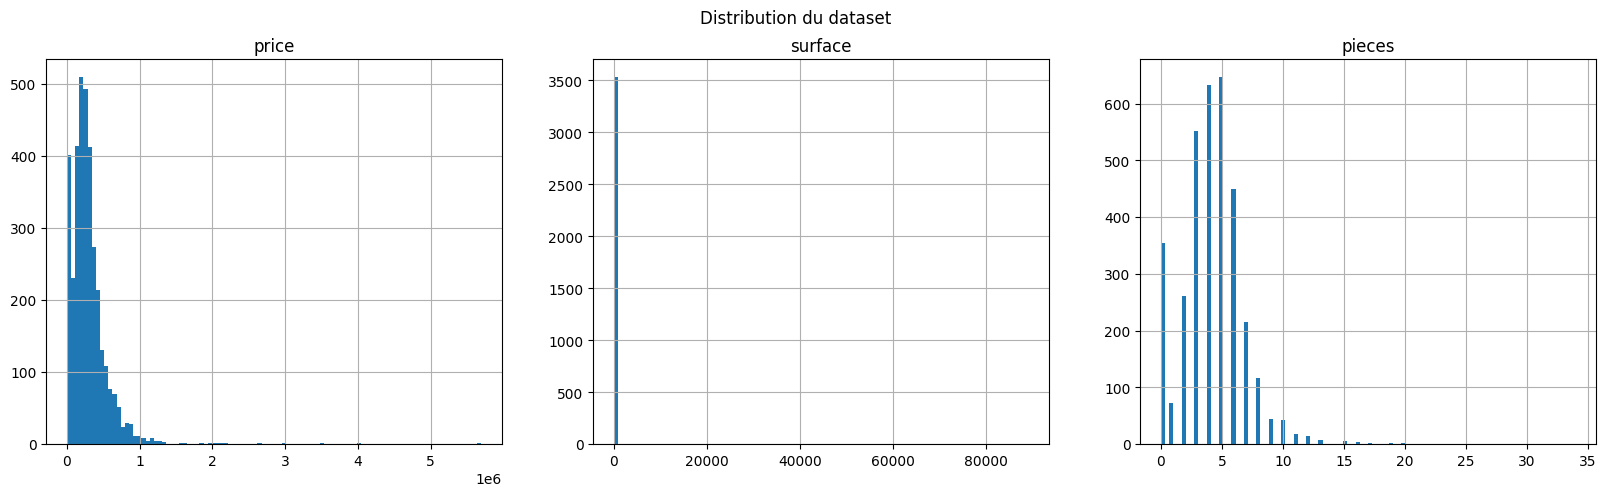

In [58]:
plot_boxplots(df, ["price", "surface", "pieces"])
plot_histogram(df,["price", "surface", "pieces"])

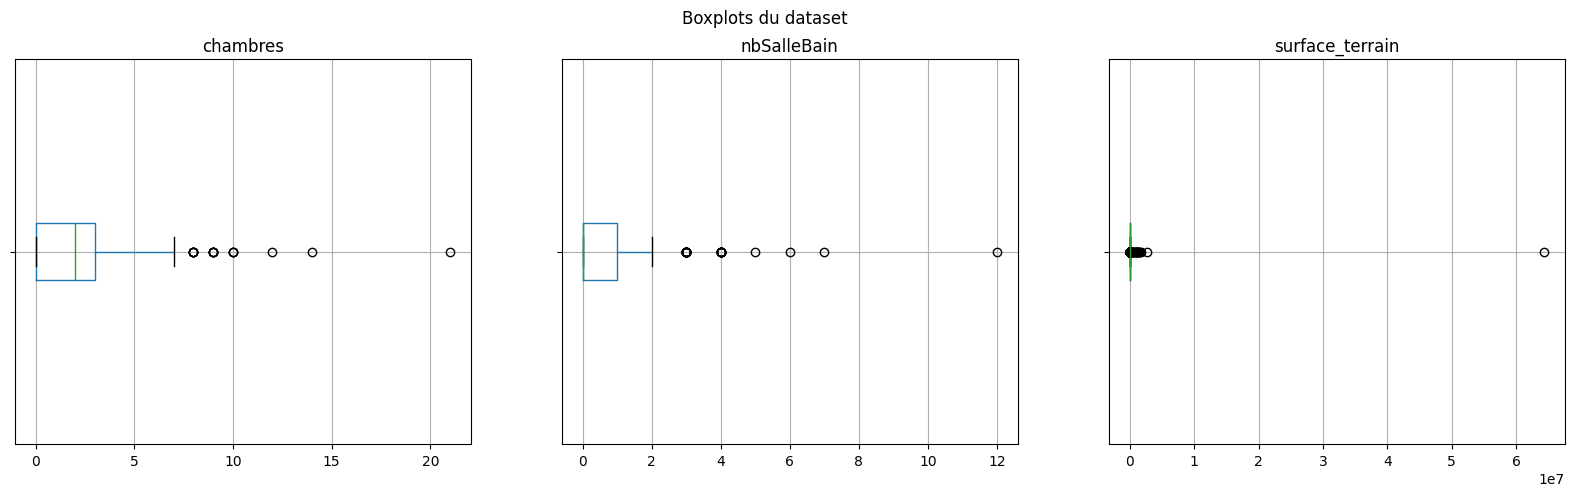

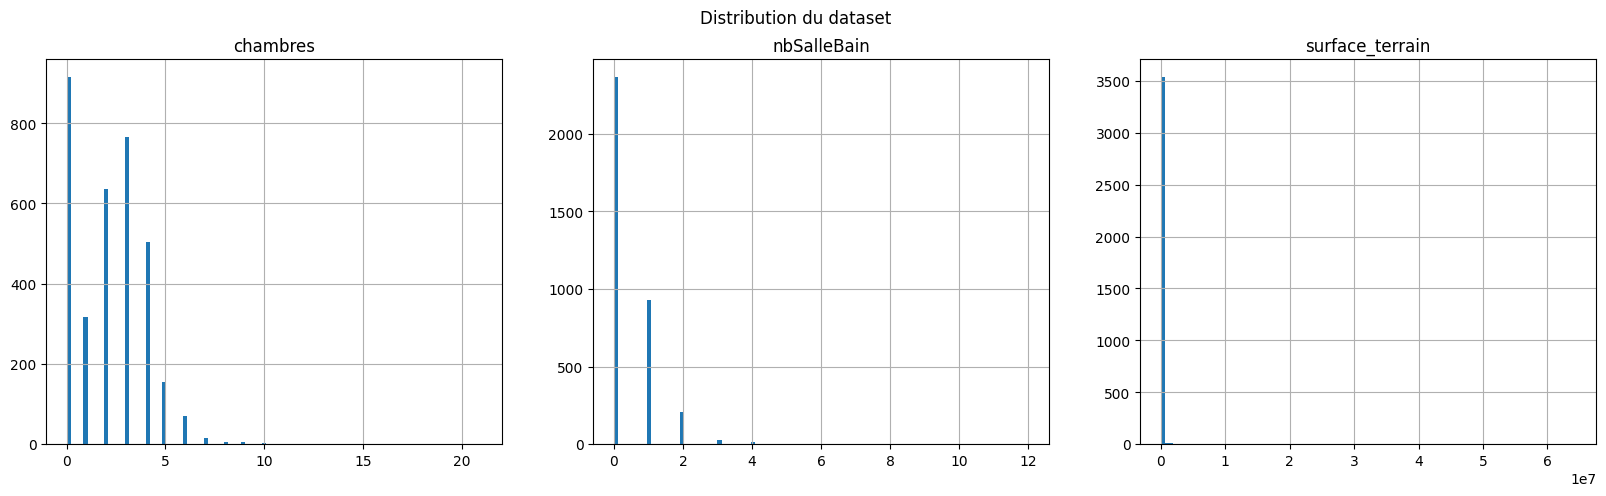

In [59]:
plot_boxplots(df, ["chambres", "nbSalleBain", "surface_terrain"])
plot_histogram(df,["chambres", "nbSalleBain", "surface_terrain"])

<h4> Suppression des outliers: </h4>
<p> 
    on va utiliser deux methodes percentiles et quartile.
</p>

<p> 
    on va definir une fonction permettant d'afficher la distribution d'une valeur avec une mise en valeur des outliers.
</p>

In [60]:
from typing import Union, Any, List, Iterable, Tuple, Dict, Callable

def plot_distribution_with_bounds(
    series: pd.Series,  
    bounds: Tuple[float, float],
    ax: plt.Axes = None,
    title: str = "",
    figsize: Tuple[float, float] = (10, 5),
    bins: int = 100,
):
    series.plot.hist(bins=bins, ax=ax)

    min, max = bounds
    ax.axvspan(0.0, min, color="red", alpha=0.5)
    ax.axvspan(max, series.max(), color="red", alpha=0.5)

In [61]:
def display_outliers_method(
    df: pd.DataFrame, 
    columns,
    method: Callable[[pd.Series, Any], Tuple[float, float]],
    **kwargs
):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 5))
    axes[0].set_title(columns[0])
    axes[1].set_title(columns[0])
    axes[2].set_title(columns[0])

    for idx, col in zip(range(3), columns):
        ax = axes[idx]
        ax.set_title(col)
        series = df[col]
        bounds = method(series, **kwargs)
        print(f"Bounds for column \"{col}\": {bounds}")
        plot_distribution_with_bounds(
            series,
            bounds,
            ax
        )
    plt.show()

<h4> Methode percentile : </h4>

In [62]:
def compute_percentile_bounds(
    series: pd.Series, 
    cutoff_percentage: float = 1.0
) -> Tuple[float, float]:
    """ Returns (lower, upper) bounds
    """
    quantile = cutoff_percentage / 100.0
    return series.quantile(quantile), series.quantile(1 - quantile)

Bounds for column "price": (0.0, 1095200.0000000007)
Bounds for column "surface": (0.0, 435.3900000000044)
Bounds for column "pieces": (0.0, 12.0)


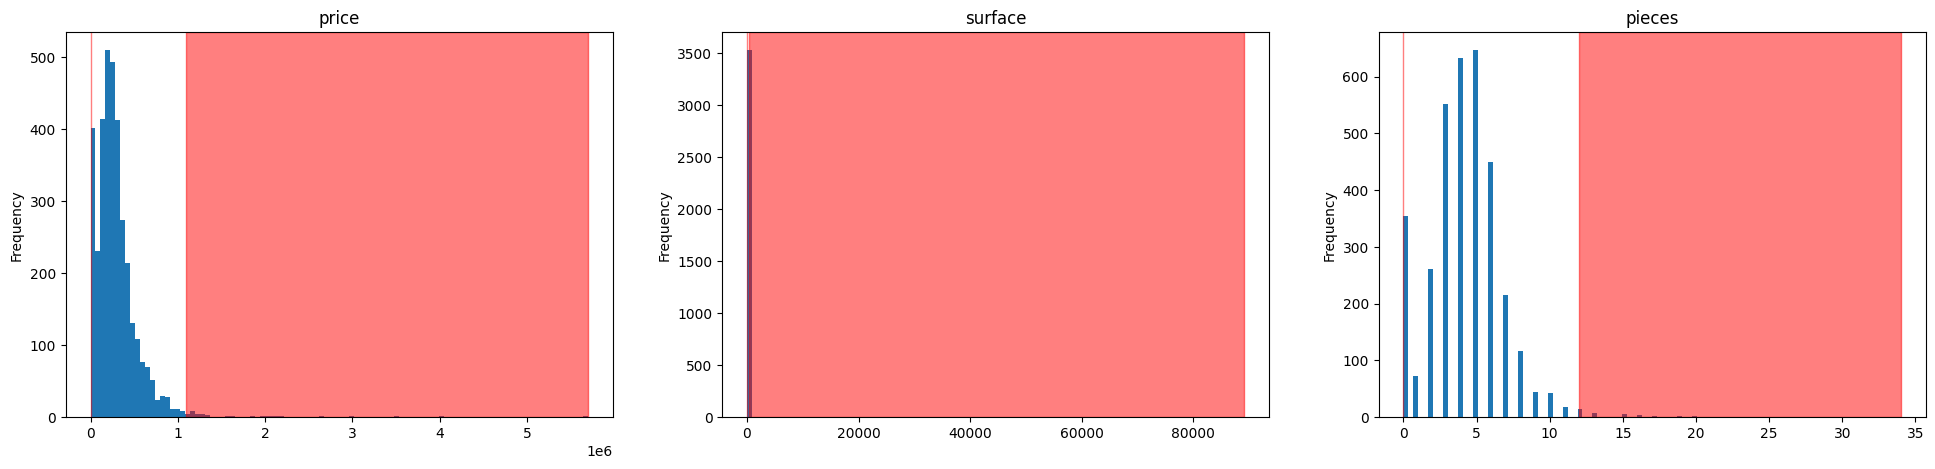

Bounds for column "chambres": (0.0, 6.0)
Bounds for column "nbSalleBain": (0.0, 3.0)
Bounds for column "surface_terrain": (0.0, 93928.9999999998)


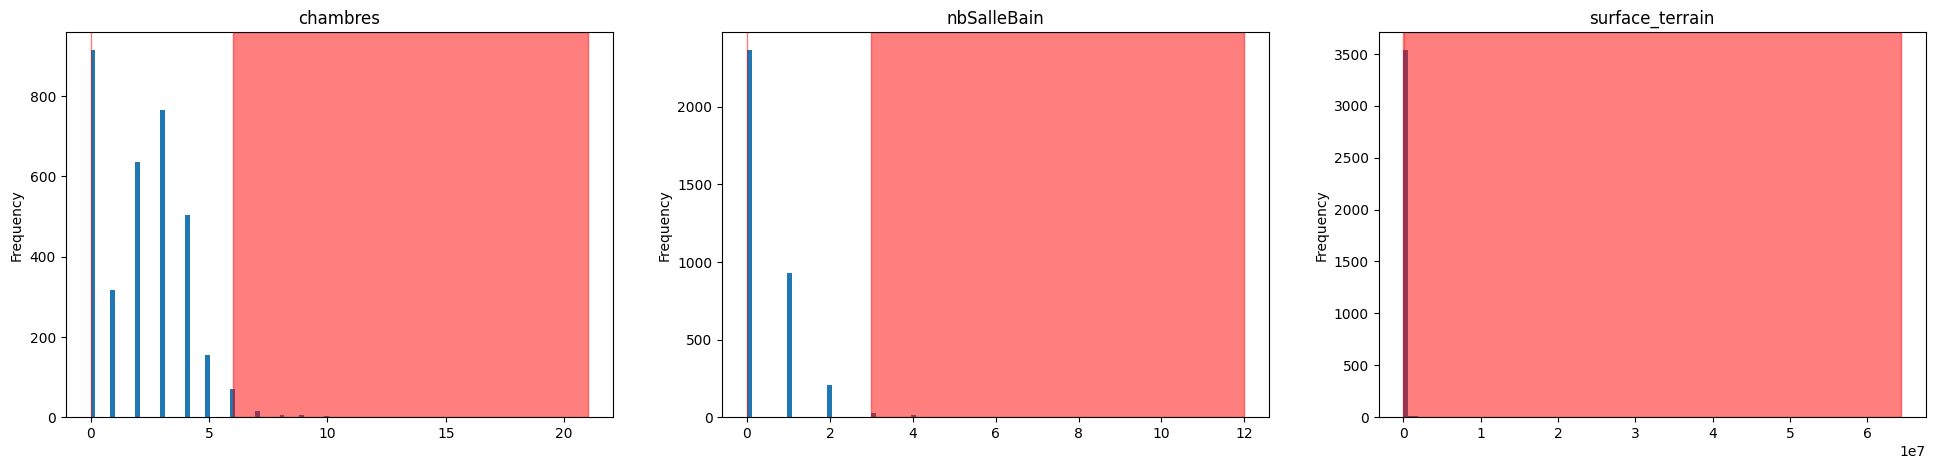

In [63]:
display_outliers_method(
    df,
    ("price", "surface", "pieces"),
    compute_percentile_bounds,
    cutoff_percentage = 1.0
)
display_outliers_method(
    df,
    ("chambres", "nbSalleBain", "surface_terrain"),
    compute_percentile_bounds,
    cutoff_percentage = 1.0
)

<h4> Method Interquartile Range: <h4>

In [64]:
def compute_interquartile_range_method(series: pd.Series) -> Tuple[float, float]:
    quantile_25, quantile_75 = series.quantile([0.25, 0.75])
    iqr = quantile_75 - quantile_25
    print(quantile_25, quantile_75)
    print(iqr)
    lower = quantile_25 - 1.5 * iqr
    upper = quantile_75 + 1.5 * iqr
    return lower, upper

Bounds for column "price": (0.0, 1095200.0000000007)
Bounds for column "surface": (0.0, 435.3900000000044)
Bounds for column "pieces": (0.0, 12.0)


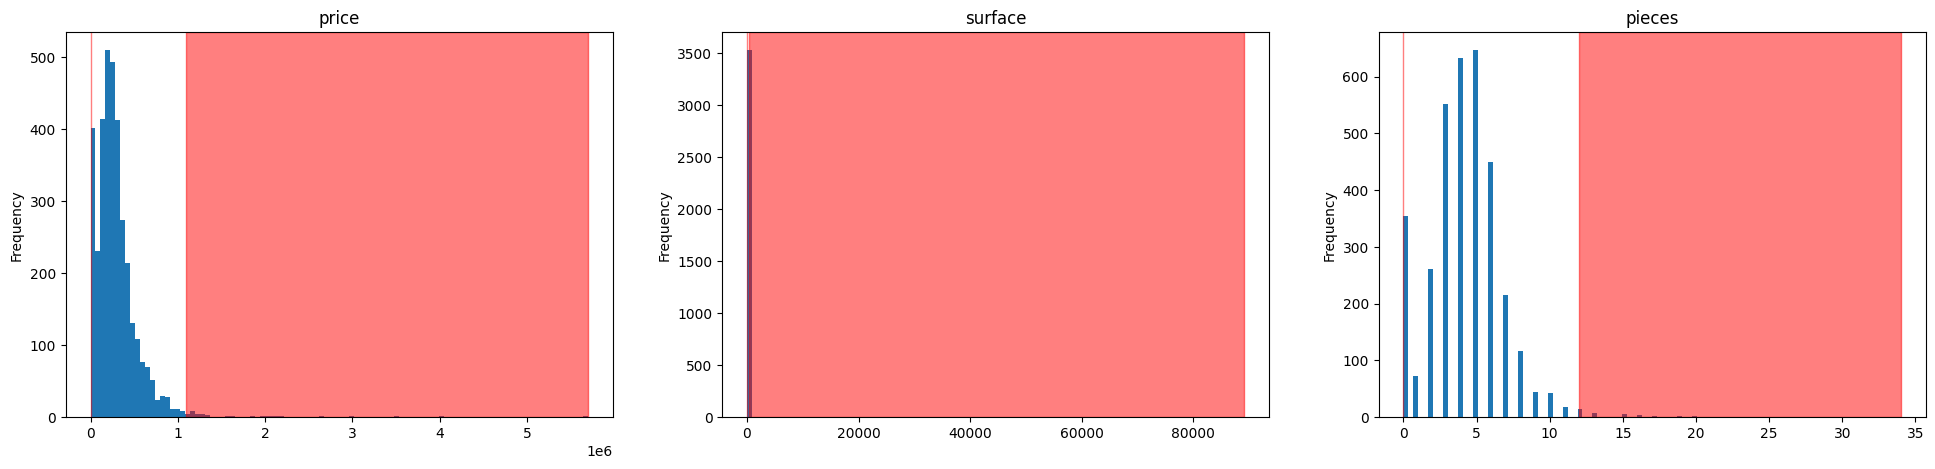

Bounds for column "chambres": (0.0, 6.0)
Bounds for column "nbSalleBain": (0.0, 3.0)
Bounds for column "surface_terrain": (0.0, 93928.9999999998)


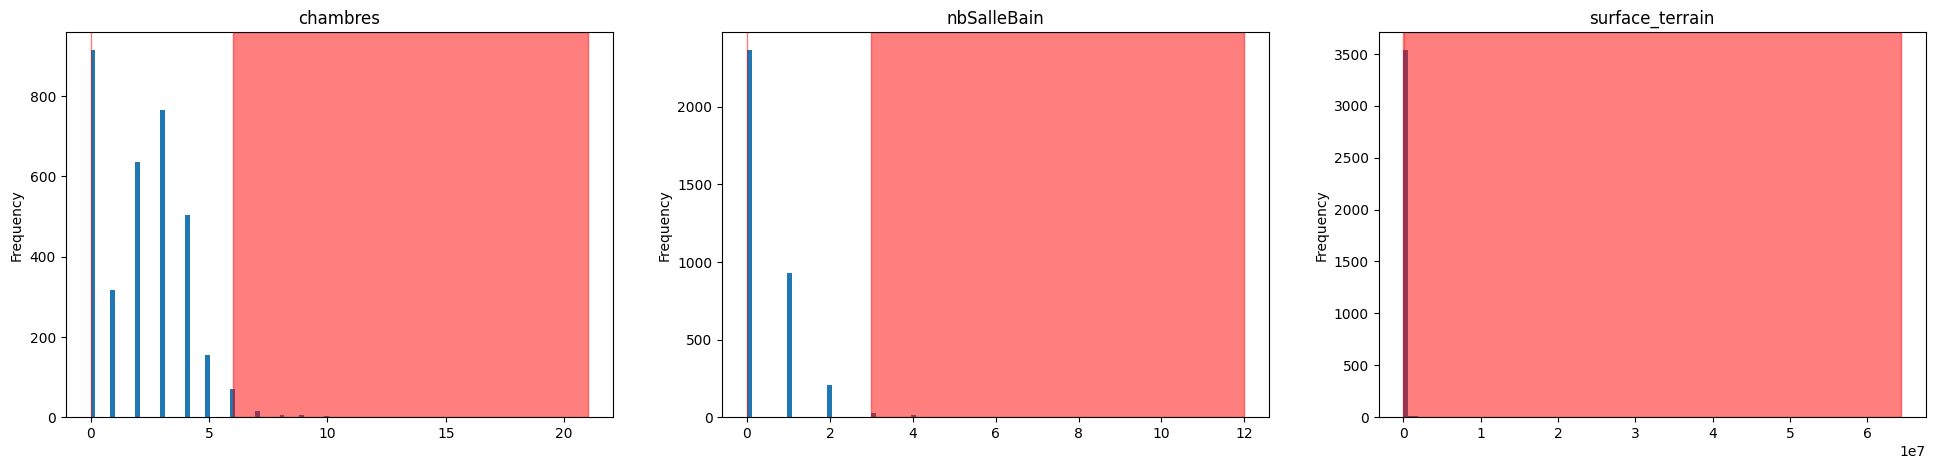

In [65]:
display_outliers_method(
    df,
    ("price", "surface", "pieces"),
    compute_percentile_bounds
)
display_outliers_method(
    df,
    ("chambres", "nbSalleBain", "surface_terrain"),
    compute_percentile_bounds
)

<h4> Comparaison: </h4>
<p> En se basant sur les deux resulats, on peut voir que la methode interquartile range detecte plus d'outliers. Plus d'outliers va resulter à supprimer plus de données. Donc on garde la permière où on supprime peu de données.<p>
<h4> Suppression d'outliers: Methode percentile</h4>


In [66]:
def remove_outliers(
    df: pd.DataFrame, 
    cols,
    method: Callable[[pd.Series, Any, Any], Tuple[float, float]],
    *args,
    **kwargs
) -> pd.DataFrame:
    for col in cols:
        series = df[col]
        bounds = method(series, *args, **kwargs)
        df = df[df[col].between(*bounds, inclusive="both")]
    return df

In [67]:
df = remove_outliers(
    df,
    ("price", "surface", "pieces"),
    compute_percentile_bounds,
    cutoff_percentage=1.0
)

In [68]:
df

,title,ref,typeBien,ville,price,surface,pieces,chambres,cuisine,garage,surface_terrain,nbSalleBain,balcon,terrace,jardin,classEnergy,gazEmission
0,Annonce : Vente Maison Sanguinet (40460) 116 m...,992769111492,Maison,Sanguinet,499000.0,116.0,5.0,0.0,Non,Oui,7702,1,Non,Non,Non,D,B
1,Annonce : Vente Maison Montroy (17220) 96 m² (...,992769747084,Maison,Montroy,337600.0,96.0,5.0,0.0,Oui,Oui,3892,1,Non,Non,Non,ND,ND
2,Annonce : Vente Maison Montreuil-aux-Lions (02...,992769747083,Maison,Montreuil,113000.0,63.0,3.0,0.0,Oui,Non,0,1,Non,Non,Non,C,A
3,Annonce : Vente Maison Château-Thierry (02400)...,992769747080,Maison,Chateau,262000.0,127.0,6.0,0.0,Oui,Oui,8202,1,Non,Non,Non,C,A
5,Annonce : Vente Maison Eysines (33320) 128 m² ...,992769747081,Maison,Eysines,543400.0,128.0,7.0,0.0,Oui,Oui,7152,1,Non,Non,Non,C,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3778,Appartement - 3 pièces - 49 m² - Toulouse - 31300,8767,Appartement,Toulouse,190460.0,49.0,3.0,2.0,Oui,Non,49,1,Non,Non,Non,F,D
3779,Maison - 4 pièces - 117.99 m² - Morgny - 27150,8770,Maison,Morgny,213200.0,117.0,4.0,2.0,Oui,Non,0,1,Non,Non,Oui,ND,ND
3780,Maison - 5 pièces - 83.01 m² - Sérifontaine - ...,8766,Maison,Sérifontaine,150180.0,83.0,5.0,3.0,Oui,Non,0,1,Non,Non,Non,F,C
3781,Maison - 6 pièces - 198 m² - Wy-dit-Joli-Villa...,8765,Maison,Wy-dit-Joli-Village,664928.0,198.0,6.0,4.0,Oui,Non,0,2,Non,Oui,Oui,B,A


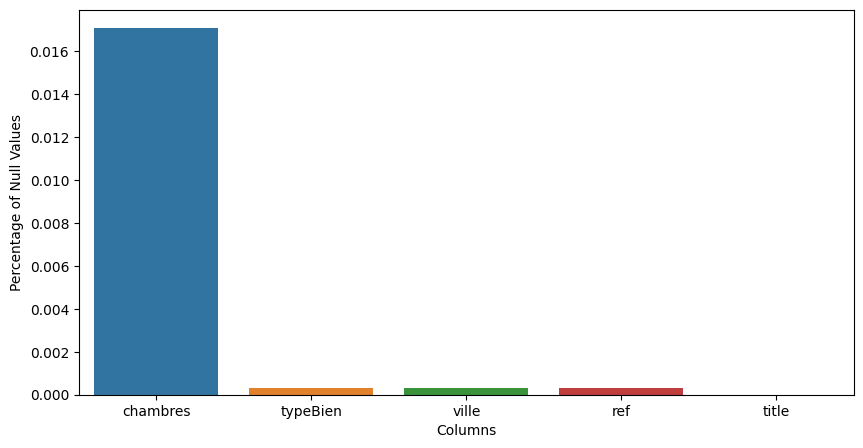

In [69]:
checkNullValues(df)

In [70]:
df.to_csv('finalDataset.csv', sep='\t', encoding='utf-8')